In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('data/^NDX_raw_data.csv')
data.rename(columns={'Date': 'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'}, inplace=True)

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5033 entries, 0 to 5032
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    5033 non-null   object 
 1   open    5033 non-null   float64
 2   high    5033 non-null   float64
 3   low     5033 non-null   float64
 4   close   5033 non-null   float64
 5   volume  5033 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 236.0+ KB


In [3]:
data.head()

,date,open,high,low,close,volume
0,2004-01-02 00:00:00-05:00,1474.160034,1479.589966,1458.510010,1463.569946,1666780000
1,2004-01-05 00:00:00-05:00,1474.550049,1496.579956,1474.189941,1496.579956,2362910000
2,2004-01-06 00:00:00-05:00,1492.410034,1504.469971,1486.589966,1501.260010,2273220000
3,2004-01-07 00:00:00-05:00,1498.380005,1514.449951,1491.199951,1514.260010,2294280000
4,2004-01-08 00:00:00-05:00,1524.060059,1530.650024,1513.339966,1530.650024,2683950000


In [4]:
data.date = data.date.str[:-6]

In [5]:
data.date = pd.to_datetime(data.date, dayfirst=True, format="%Y-%m-%d %H:%M:%S")

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5033 entries, 0 to 5032
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    5033 non-null   datetime64[ns]
 1   open    5033 non-null   float64       
 2   high    5033 non-null   float64       
 3   low     5033 non-null   float64       
 4   close   5033 non-null   float64       
 5   volume  5033 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 236.0 KB


In [7]:
data = data.sort_values(by='date',ascending=False)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
data.set_index('date', inplace=True)

In [10]:
time_series = data.close

In [11]:
time_series

date
2023-12-29    16825.929688
2023-12-28    16898.470703
2023-12-27    16906.800781
2023-12-26    16878.460938
2023-12-22    16777.400391
                  ...     
2004-01-08     1530.650024
2004-01-07     1514.260010
2004-01-06     1501.260010
2004-01-05     1496.579956
2004-01-02     1463.569946
Name: close, Length: 5033, dtype: float64

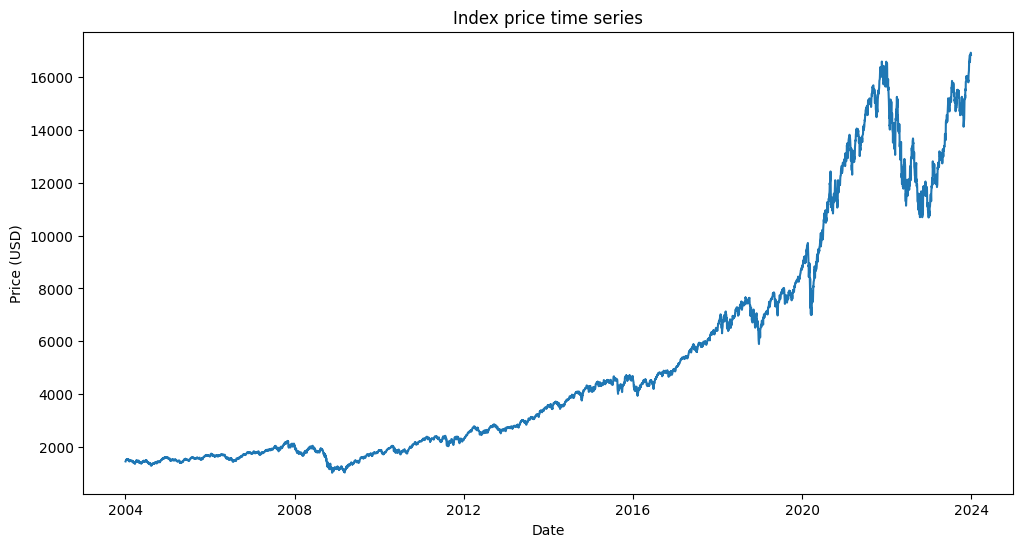

In [12]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=time_series.index, y=time_series)
plt.title('Index price time series')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [14]:
decomposition = seasonal_decompose(time_series, model='additive', period=365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

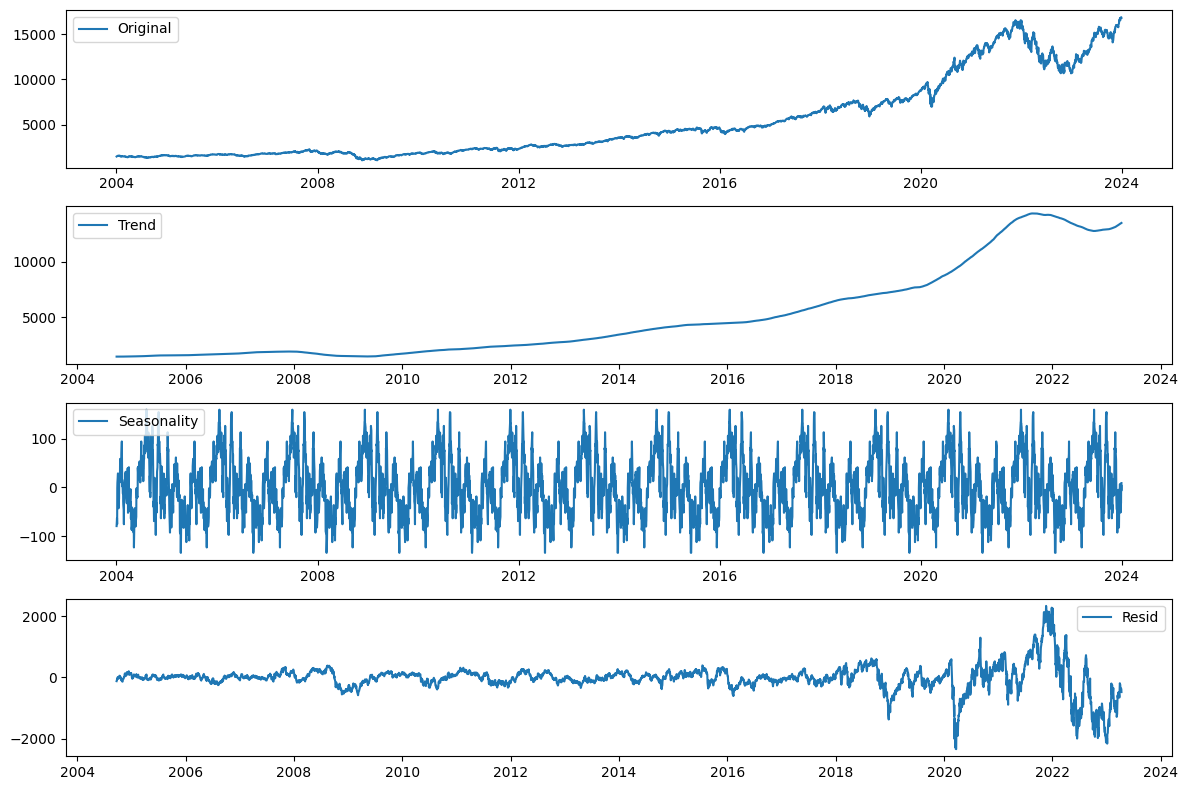

In [15]:
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(time_series, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Resid')
plt.legend(loc='best')
plt.tight_layout()

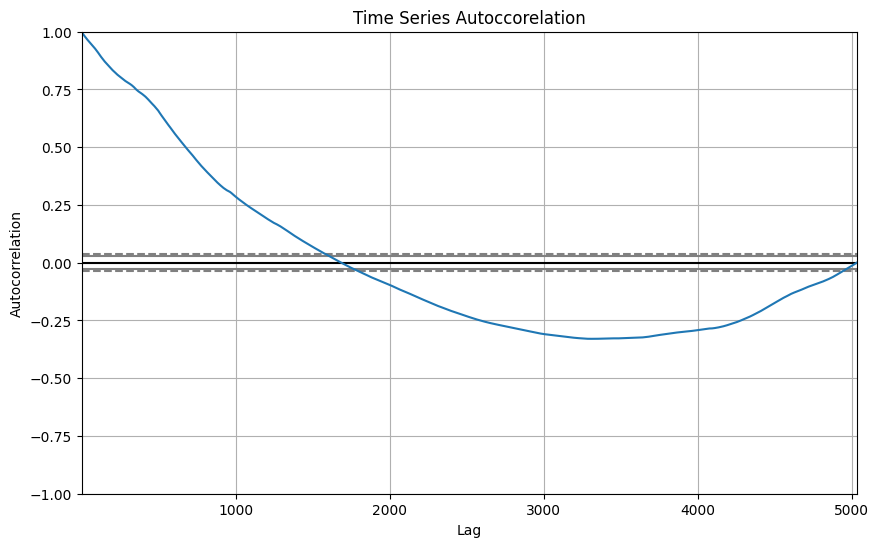

In [16]:
# Autocorrelation
plt.figure(figsize=(10, 6))
pd.plotting.autocorrelation_plot(time_series)
plt.title('Time Series Autoccorelation')
plt.show()

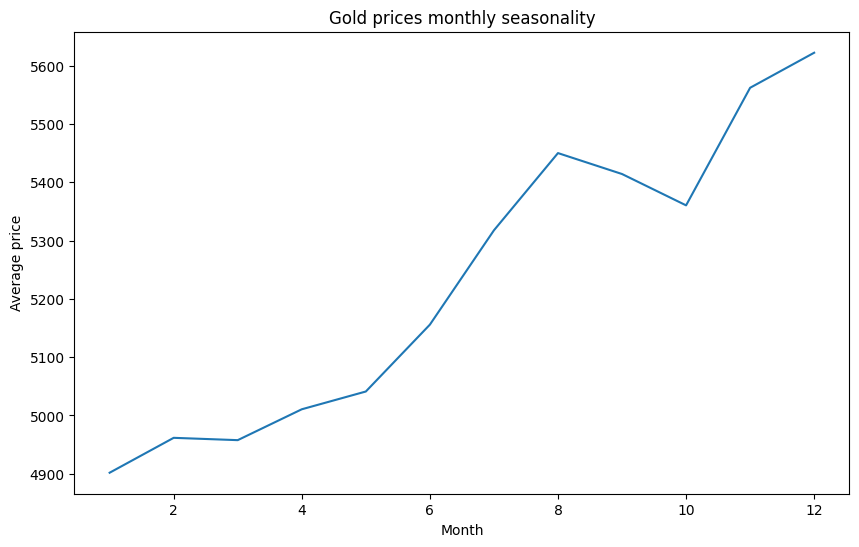

In [17]:
monthly_seasonality = time_series.groupby(time_series.index.month).mean()
plt.figure(figsize=(10, 6))
monthly_seasonality.plot(kind='line')
plt.title('Gold prices monthly seasonality')
plt.xlabel('Month')
plt.ylabel('Average price')
plt.xticks(rotation=0)
plt.show()

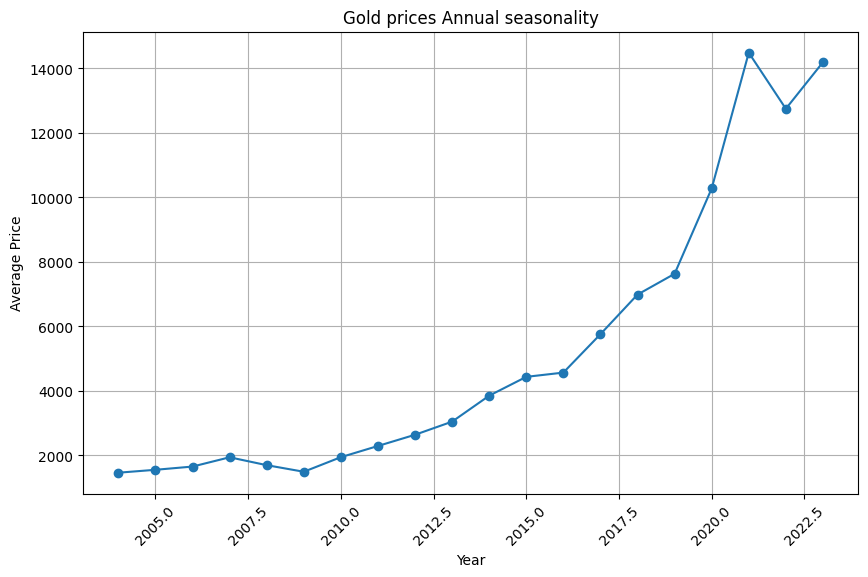

In [18]:
yearly_seasonality = time_series.groupby(time_series.index.year).mean()
plt.figure(figsize=(10, 6))
yearly_seasonality.plot(kind='line', marker='o')
plt.title('Gold prices Annual seasonality')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [19]:
price_series = pd.DataFrame({'price': time_series.values}, index=time_series.index)

In [20]:
# Importing necessary libraries to normalize
from sklearn.preprocessing import MinMaxScaler

# Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(price_series.price.values.reshape(-1, 1))

## Creating sequences
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])

    return np.array(dataX), np.array(dataY)

time_step = 60
X, y = create_dataset(df_scaled, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

## Split data into training and test sets
split_fraction = 0.8
train_size = int(len(X) * split_fraction)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input

model = Sequential()
model.add(Input(shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

2024-04-19 07:35:04.167957: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 07:35:04.414184: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 07:35:04.414275: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 07:35:04.457154: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-19 07:35:04.610082: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 07:35:08.033264: W tensorflow/compiler/tf2tensorrt/utils/py_utils.

In [22]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose=2)

Epoch 1/100
63/63 - 9s - loss: 0.0124 - val_loss: 7.5633e-05 - 9s/epoch - 148ms/step
Epoch 2/100
63/63 - 4s - loss: 0.0019 - val_loss: 1.2596e-05 - 4s/epoch - 62ms/step
Epoch 3/100
63/63 - 4s - loss: 0.0017 - val_loss: 5.4185e-05 - 4s/epoch - 63ms/step
Epoch 4/100
63/63 - 4s - loss: 0.0015 - val_loss: 1.3057e-05 - 4s/epoch - 62ms/step
Epoch 5/100
63/63 - 4s - loss: 0.0013 - val_loss: 5.0262e-05 - 4s/epoch - 63ms/step
Epoch 6/100
63/63 - 4s - loss: 0.0011 - val_loss: 5.5952e-06 - 4s/epoch - 61ms/step
Epoch 7/100
63/63 - 4s - loss: 0.0011 - val_loss: 1.9539e-05 - 4s/epoch - 61ms/step
Epoch 8/100
63/63 - 4s - loss: 0.0010 - val_loss: 5.7676e-06 - 4s/epoch - 62ms/step
Epoch 9/100
63/63 - 4s - loss: 9.6819e-04 - val_loss: 3.8709e-05 - 4s/epoch - 61ms/step
Epoch 10/100
63/63 - 4s - loss: 8.3192e-04 - val_loss: 5.7887e-06 - 4s/epoch - 64ms/step
Epoch 11/100
63/63 - 4s - loss: 9.2258e-04 - val_loss: 8.5847e-06 - 4s/epoch - 63ms/step
Epoch 12/100
63/63 - 4s - loss: 7.9131e-04 - val_loss: 9.0608

In [23]:
# Model evaluation on test set
test_loss = model.evaluate(X_test, y_test)
print(f'Model evaluation on test set: {test_loss}')

32/32 [==============================] - 1s 20ms/step - loss: 7.7203e-06
Model evaluation on test set: 7.720267603872344e-06


In [24]:
# Generate predictions
predictions = model.predict(X_test)
# Reverse normalization for predictions
actual_predictions = scaler.inverse_transform(predictions)

32/32 [==============================] - 2s 19ms/step


In [25]:
y_test_resized = y_test.reshape(-1, 1)
y_test_reales = scaler.inverse_transform(y_test_resized)

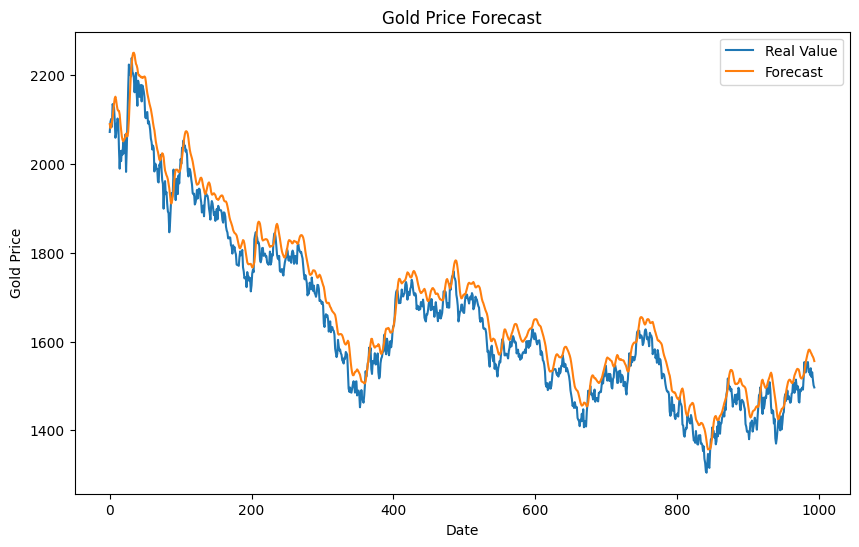

In [26]:
plt.figure(figsize=(10,6))
plt.plot(y_test_reales, label='Real Value')
plt.plot(actual_predictions, label='Forecast')
plt.title('Gold Price Forecast')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.show()

In [34]:
last_days = df_scaled[:time_step]

future_predictions = []

for i in range(60):
    # Predict using the last available days
    pred = model.predict(last_days.reshape(1, time_step, 1))
    # Add the new prediction at the start of your available data
    last_days = np.insert(last_days, 0, pred, axis=0)
    # Ensure the array maintains the correct size
    last_days = last_days[:time_step]
    # Save the prediction
    future_predictions.append(pred[0, 0])

# Reverse the predictions to match the correct temporal order
#future_predictions = future_predictions[::-1]

# Reverse normalization
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

1/1 [==============================] - 0s 31ms/step


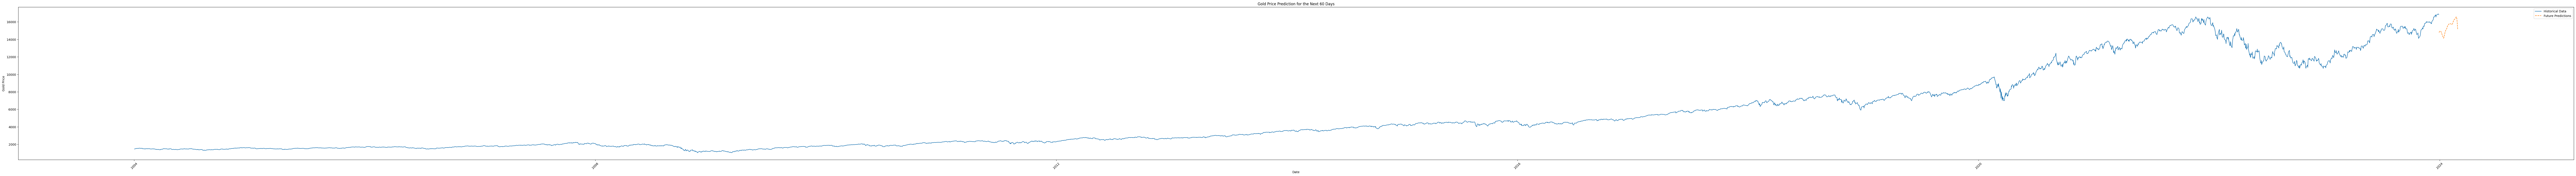

In [35]:
#Generate future dates without the 'closed' argument
# Assuming gold_series.index[0] is the most recent date

# The last date in your data
last_date = price_series.index[0]

# Generate 60 future dates starting from the day after the last date
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Ensure the display is correctly adjusted
plt.figure(figsize=(150, 9))
plt.plot(price_series.index, price_series.price, label='Historical Data')

# Since future dates are generated in order, but your data is in reverse,
# we might need to reverse future_dates or gold_series.index to match them on the graph.
plt.plot(future_dates, future_predictions, label='Future Predictions', linestyle='--')
plt.title('Gold Price Prediction for the Next 60 Days')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.xticks(rotation=45)
# If your historical data is in reverse (most recent date first),
# we should also reverse the X-axis to show recent dates on the left
plt.show()

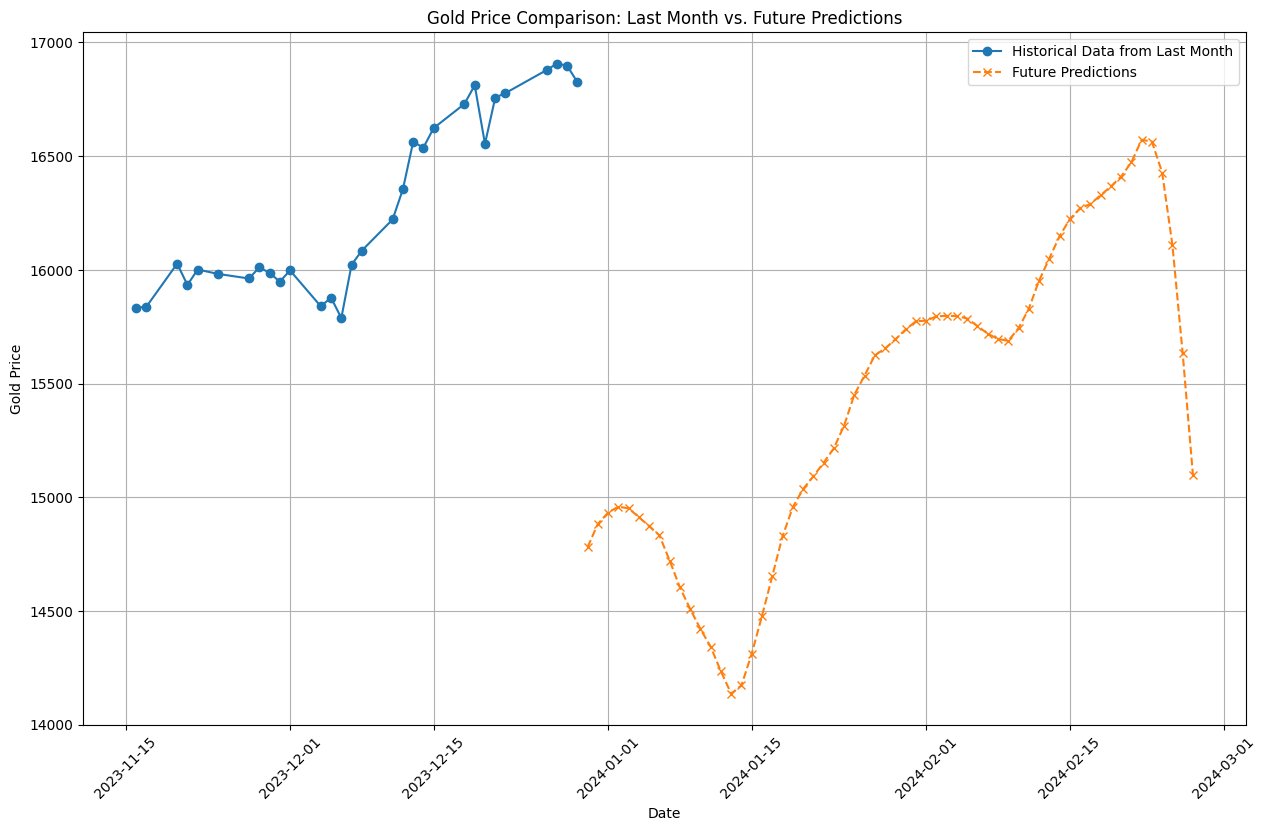

In [36]:
last_month_data = price_series.head(30)
last_month_dates = last_month_data.index
plt.figure(figsize=(15, 9))

# Last month's data
plt.plot(last_month_dates, last_month_data.price, label='Historical Data from Last Month', marker='o')

# Future predictions
# Ensure future_dates start right after the last day of your historical data
plt.plot(future_dates, future_predictions, label='Future Predictions', linestyle='--', marker='x')
#plt.plot(future_dates[::-1], future_predictions, label='Future Predictions', linestyle='--')
plt.title('Gold Price Comparison: Last Month vs. Future Predictions')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

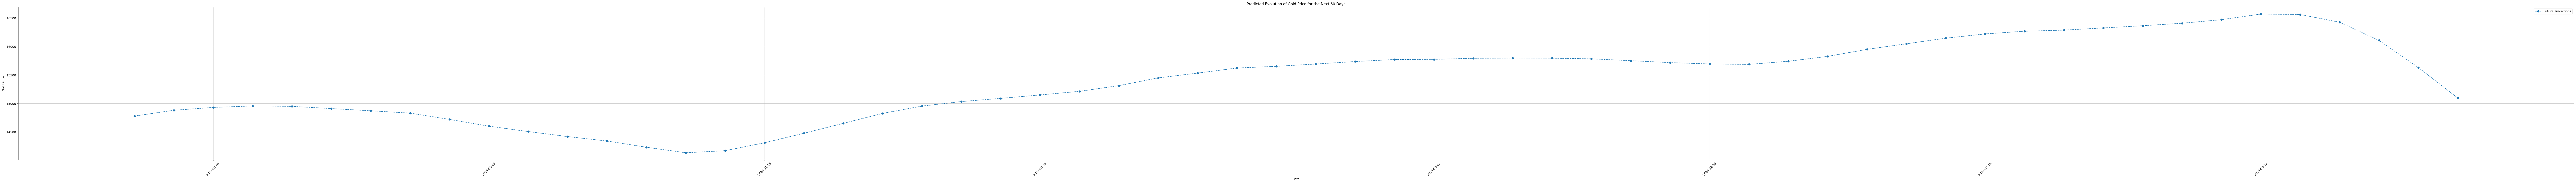

In [37]:
# This code assumes that 'future_dates' is a pandas DatetimeIndex of prediction dates
# and 'future_predictions' contains your predicted values.
plt.figure(figsize=(150, 9))
plt.plot(future_dates, future_predictions, label='Future Predictions', linestyle='--', marker='o')
plt.title('Predicted Evolution of Gold Price for the Next 60 Days')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()